In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv(r'C:\Users\Antonette\Downloads\pink.csv')

In [ ]:
data.isnull().sum()

TimeTrend             0
FlightDate            0
Year                  0
Month                 0
DayofMonth            0
DayOfWeek             0
TimeOfDay             0
Airline               0
Origin                0
Dest                  0
Distance              0
OriginAirportID       0
DestAirportID         0
ESTDepTotalMinutes    0
ESTArrTotalMinutes    0
DepTotalMinutes       0
DepDelay              0
Holiday               0
Route                 0
AvgDelayPerRoute      0
AvgDelayPerAirline    0
dtype: int64

In [ ]:
delay_data = data[(data['Airline'] == 'Delta Air Lines Inc.') & (data['Year']==2021)]

In [ ]:
delay_data.columns

Index(['TimeTrend', 'FlightDate', 'Year', 'Month', 'DayofMonth', 'DayOfWeek',
       'TimeOfDay', 'Airline', 'Origin', 'Dest', 'Distance', 'OriginAirportID',
       'DestAirportID', 'ESTDepTotalMinutes', 'ESTArrTotalMinutes',
       'DepTotalMinutes', 'DepDelay', 'Holiday', 'Route', 'AvgDelayPerRoute',
       'AvgDelayPerAirline'],
      dtype='object')

In [ ]:
delay_data['FlightDate'] = pd.to_datetime(delay_data['FlightDate'])
daily_avg_delay = delay_data.groupby('FlightDate')['DepDelay'].mean().reset_index()
daily_avg_delay.columns = ['FlightDate', 'DelayPerDay']

C:\Users\Antonette\AppData\Local\Temp\ipykernel_17888\768046268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_data['FlightDate'] = pd.to_datetime(delay_data['FlightDate'])


In [ ]:
daily_avg_delay['Month'] = daily_avg_delay['FlightDate'].dt.month
daily_avg_delay['Day'] = daily_avg_delay['FlightDate'].dt.day
daily_avg_delay = daily_avg_delay[['FlightDate', 'Month', 'Day', 'DelayPerDay']]

In [ ]:
merged_data = pd.merge(daily_avg_delay, delay_data[['FlightDate', 'DayOfWeek']], on='FlightDate', how='left')
daily_avg_delay = merged_data.drop_duplicates(subset=['FlightDate', 'DelayPerDay'])

In [ ]:
daily_avg_delay = daily_avg_delay[['FlightDate', 'Month', 'Day', 'DayOfWeek', 'DelayPerDay']]

In [ ]:
daily_avg_delay.dtypes

FlightDate     datetime64[ns]
Month                   int32
Day                     int32
DayOfWeek               int64
DelayPerDay           float64
dtype: object

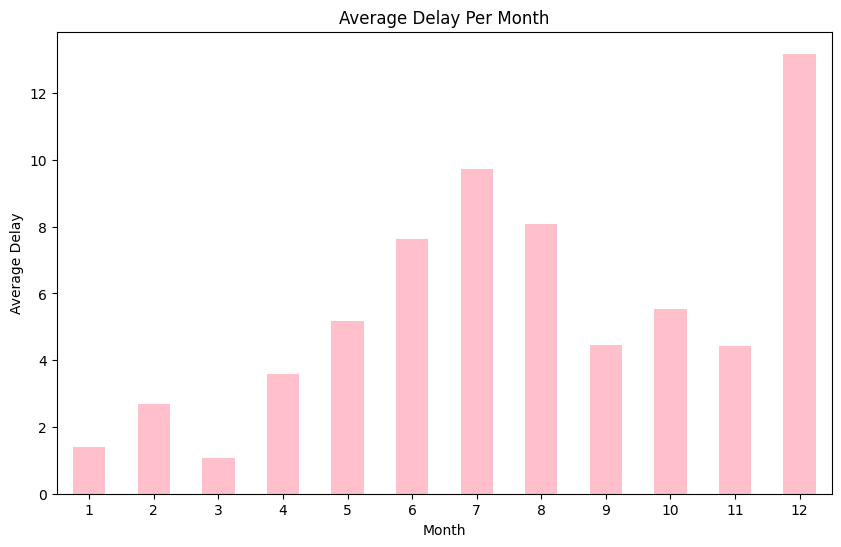

In [ ]:
import matplotlib.pyplot as plt

average_delay_per_month = daily_avg_delay.groupby('Month')['DelayPerDay'].mean()

plt.figure(figsize=(10, 6))
average_delay_per_month.plot(kind='bar', color='pink')
plt.title('Average Delay Per Month')
plt.xlabel('Month')
plt.ylabel('Average Delay')
plt.xticks(rotation=0)
plt.show()


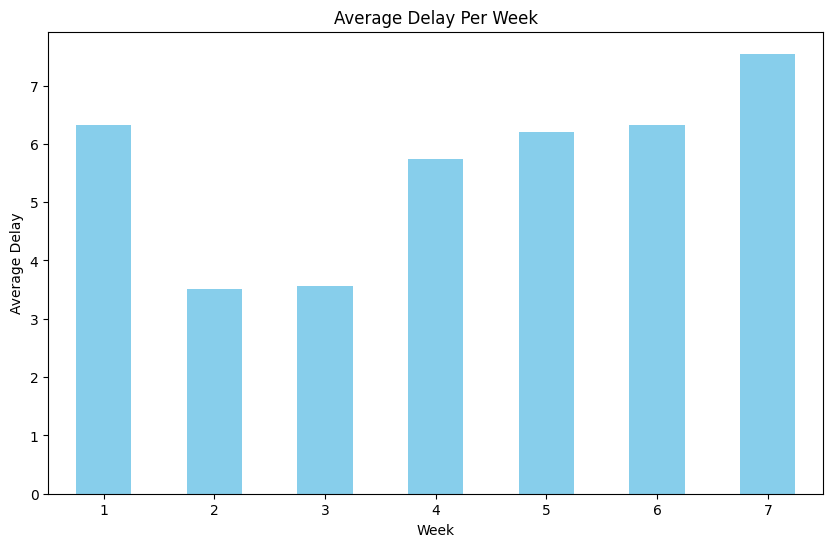

In [ ]:
average_delay_per_week = daily_avg_delay.groupby('DayOfWeek')['DelayPerDay'].mean()

plt.figure(figsize=(10, 6))
average_delay_per_week.plot(kind='bar', color='skyblue')
plt.title('Average Delay Per Week')
plt.xlabel('Week')
plt.ylabel('Average Delay')
plt.xticks(rotation=0)
plt.show()

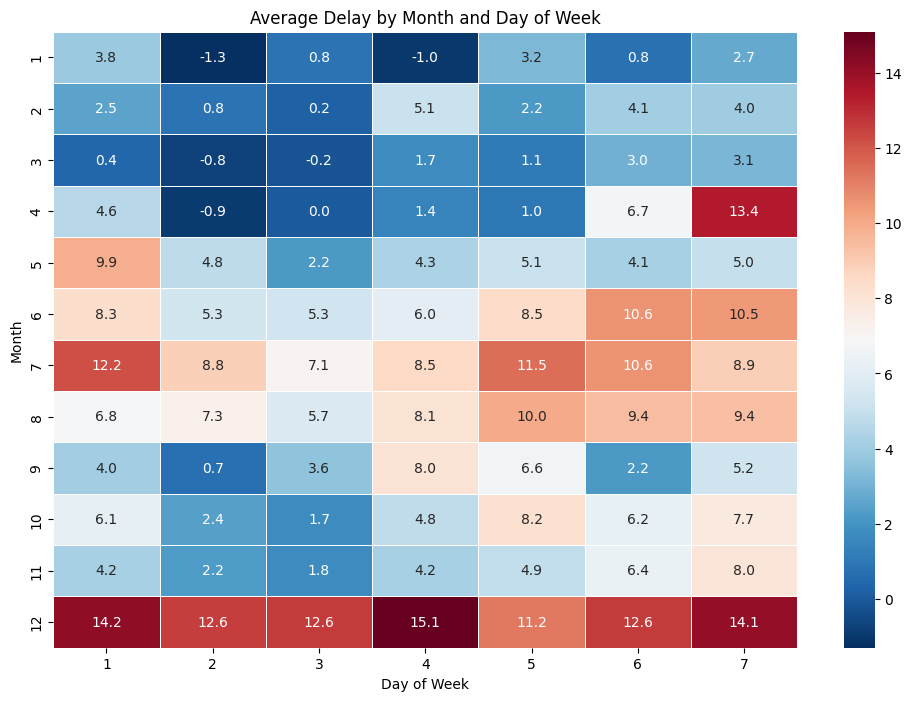

In [ ]:
import seaborn as sns

delayyy = daily_avg_delay.pivot_table(index='Month', columns='DayOfWeek', values='DelayPerDay')
plt.figure(figsize=(12, 8))
sns.heatmap(delayyy, cmap='RdBu_r', annot=True, fmt=".1f", linewidths=.5)
plt.title('Average Delay by Month and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Month')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for column in daily_avg_delay.columns:
    if daily_avg_delay[column].dtype == 'datetime64[ns]':
        daily_avg_delay[column] = label_encoder.fit_transform(daily_avg_delay[column])

In [ ]:
daily_avg_delay.dtypes

FlightDate       int64
Month            int32
Day              int32
DayOfWeek        int64
DelayPerDay    float64
dtype: object

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train = daily_avg_delay.iloc[:, :-1]
y_train = daily_avg_delay.iloc[:, -1]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
daily_avg_delay = pd.concat([pd.DataFrame(X_train_scaled), y_train.reset_index(drop=True)], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(daily_avg_delay, test_size=0.2)

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (292, 5)
Testing data shape: (73, 5)


In [ ]:
from numpy import array

def split_sequences(sequences, n_steps_in, n_steps_out):
    X_train, y_train = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X_train.append(seq_x)
        y_train.append(seq_y)
    return array(X_train), array(y_train)

In [ ]:
n_steps_in, n_steps_out = 3, 1

X_train, y_train = split_sequences(array(train_data), n_steps_in, n_steps_out)
X_test, y_test = split_sequences(array(test_data), n_steps_in, n_steps_out)

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.0000001)

## LSTM

In [ ]:
LSTM_model = Sequential()

LSTM_model.add(LSTM(500, return_sequences=True, input_shape=(n_steps_in, 4)))
LSTM_model.add(LSTM(300))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(80, activation='relu'))
LSTM_model.add(Dense(n_steps_out))

optimizer = Adam(learning_rate=0.001)
LSTM_model.compile(optimizer=optimizer, loss='mse')

print(LSTM_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 500)            1010000   
                                                                 
 lstm_1 (LSTM)               (None, 300)               961200    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 80)                24080     
                                                                 
 dense_1 (Dense)             (None, 1)                 81        
                                                                 
Total params: 1,995,361
Trainable params: 1,995,361
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
LSTM_history = LSTM_model.fit(X_train, y_train, epochs=500, batch_size=150, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/500
2/2 [==============================] - 6s 483ms/step - loss: 72.9023 - val_loss: 71.6645 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 37ms/step - loss: 72.0668 - val_loss: 70.5839 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 37ms/step - loss: 70.9904 - val_loss: 69.0607 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 37ms/step - loss: 69.4677 - val_loss: 66.8090 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 36ms/step - loss: 67.2473 - val_loss: 63.4450 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 36ms/step - loss: 63.9072 - val_loss: 58.3242 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 37ms/step - loss: 59.5627 - val_loss: 51.4112 - lr: 0.0010
Epoch 8/500
2/2 [==============================] - 0s 35ms/step - loss: 53.3405 - val_loss: 44.2411 - lr: 0.0010
Epoch 9/500
2/2 [==============================] - 0s 35ms/step - loss: 49.2429 - val_loss: 39.

In [ ]:
y_pred = LSTM_model.predict(X_test)

3/3 [==============================] - 0s 8ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 4.719584397407344


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 37.975689621274746
Root Mean Squared Error: 6.162441855407217


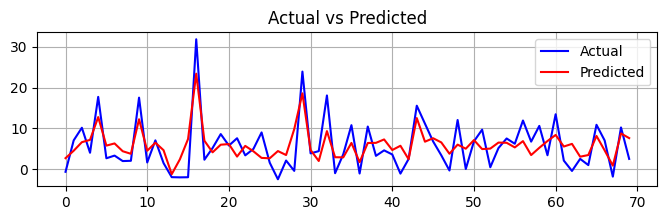

In [ ]:
plt.figure(figsize=(8, 2))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

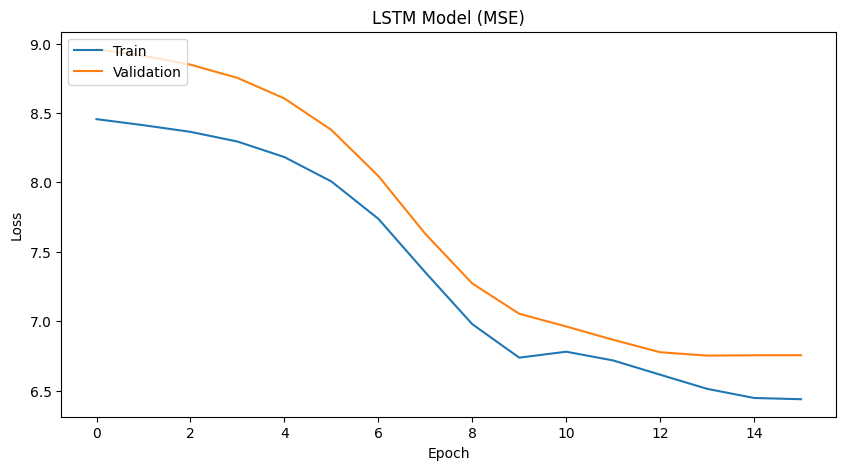

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.sqrt(LSTM_history.history['loss']))
plt.plot(np.sqrt(LSTM_history.history['val_loss']))
plt.title('LSTM Model (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

## SIMPLE RNN

In [ ]:
RNN_model = Sequential()

RNN_model.add(SimpleRNN(units=400, return_sequences=True, input_shape=(n_steps_in, 4)))
RNN_model.add(SimpleRNN(300, return_sequences=True))
RNN_model.add(SimpleRNN(250))
RNN_model.add(Dropout(0.2))
RNN_model.add(Dense(80))
RNN_model.add(Dense(n_steps_out, activation='relu'))

optimizer = Adam(learning_rate=0.001)
RNN_model.compile(optimizer=optimizer, loss='mse')

print(RNN_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 400)            162000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 3, 300)            210300    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 250)               137750    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 80)                20080     
                                                                 
 dense_3 (Dense)             (None, 1)                 81        
                                                                 
Total params: 530,211
Trainable params: 530,211
Non-tr

In [ ]:
RNN_history = RNN_model.fit(X_train, y_train, epochs=500, batch_size=150, validation_data=(X_test, y_test), verbose=1, shuffle=False, callbacks=[early_stopping, reduce_lr])

Epoch 1/500
2/2 [==============================] - 2s 299ms/step - loss: 67.3196 - val_loss: 76.1079 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 44ms/step - loss: 61.4703 - val_loss: 68.3933 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 44ms/step - loss: 58.5543 - val_loss: 64.6972 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 43ms/step - loss: 55.9785 - val_loss: 60.9860 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 43ms/step - loss: 53.8773 - val_loss: 59.4312 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 56ms/step - loss: 52.4603 - val_loss: 59.0626 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 54ms/step - loss: 51.0643 - val_loss: 60.3943 - lr: 0.0010
Epoch 8/500
2/2 [==============================] - 0s 48ms/step - loss: 48.4114 - val_loss: 60.6060 - lr: 1.0000e-04


In [ ]:
y_pred = RNN_model.predict(X_test)

3/3 [==============================] - 0s 8ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 6.052520083919829


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 59.0628592424779
Root Mean Squared Error: 7.685236446751518


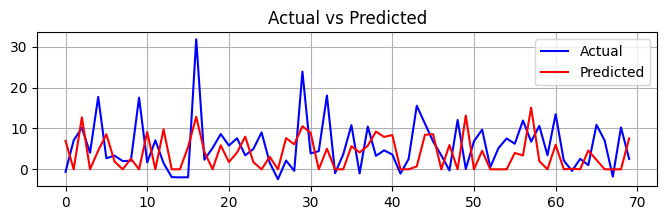

In [ ]:
plt.figure(figsize=(8, 2))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

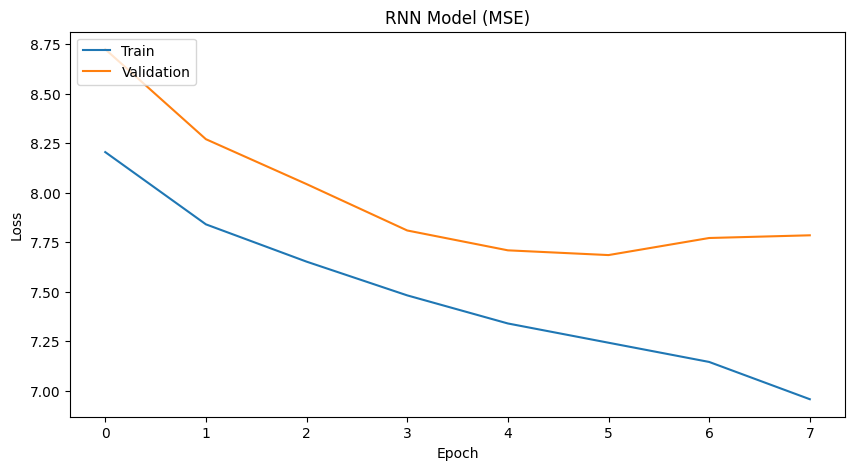

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.sqrt(RNN_history.history['loss']))
plt.plot(np.sqrt(RNN_history.history['val_loss']))
plt.title('RNN Model (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

## GRU

In [ ]:
GRU_model = Sequential()

GRU_model.add(GRU(150, return_sequences=True, input_shape=(n_steps_in, 4)))
GRU_model.add(GRU(100))
GRU_model.add(Dropout(0.2))
GRU_model.add(Dense(80))
GRU_model.add(Dense(n_steps_out, activation='relu'))

optimizer = Adam(learning_rate=0.001)
GRU_model.compile(optimizer=optimizer, loss='mse')

print(GRU_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 150)            70200     
                                                                 
 gru_1 (GRU)                 (None, 100)               75600     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 80)                8080      
                                                                 
 dense_5 (Dense)             (None, 1)                 81        
                                                                 
Total params: 153,961
Trainable params: 153,961
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
GRU_history = GRU_model.fit(X_train, y_train, epochs=500, batch_size=200, validation_data=(X_test, y_test), verbose=1, shuffle=False, callbacks=[early_stopping, reduce_lr])

Epoch 1/500
2/2 [==============================] - 2s 417ms/step - loss: 72.6439 - val_loss: 70.6271 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 27ms/step - loss: 71.5212 - val_loss: 68.7571 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 27ms/step - loss: 70.1745 - val_loss: 66.3285 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 25ms/step - loss: 68.2964 - val_loss: 63.1680 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 25ms/step - loss: 65.7252 - val_loss: 59.2235 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 26ms/step - loss: 62.9446 - val_loss: 54.9945 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 26ms/step - loss: 59.7664 - val_loss: 51.8661 - lr: 0.0010
Epoch 8/500
2/2 [==============================] - 0s 27ms/step - loss: 57.1017 - val_loss: 51.5441 - lr: 0.0010
Epoch 9/500
2/2 [==============================] - 0s 27ms/step - loss: 56.1918 - val_loss: 52.

In [ ]:
y_pred = GRU_model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 5.610602639101404


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 51.544571460899554
Root Mean Squared Error: 7.179454816411867


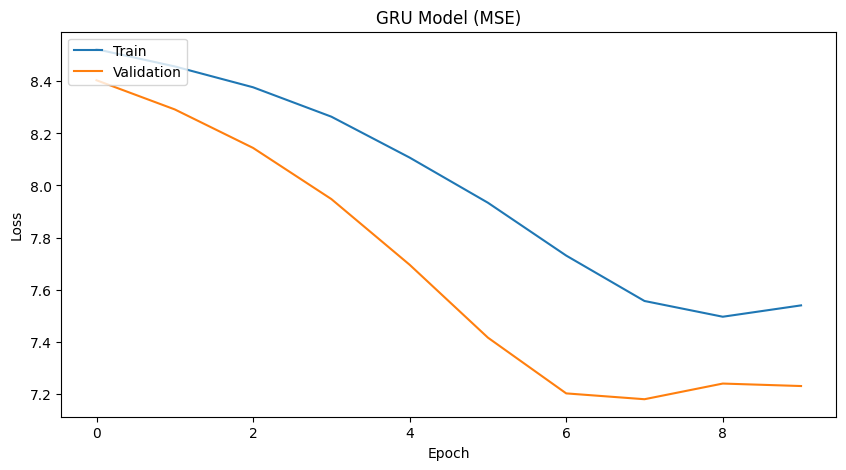

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.sqrt(GRU_history.history['loss']))
plt.plot(np.sqrt(GRU_history.history['val_loss']))
plt.title('GRU Model (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

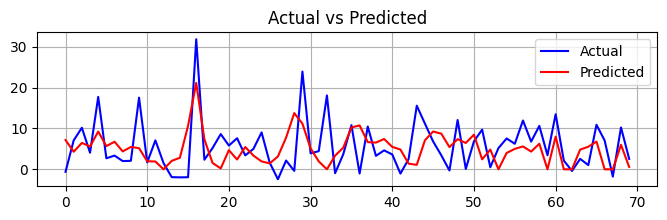

In [ ]:
plt.figure(figsize=(8, 2))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

## UNSEEN DATA (LSTM MODEL)

In [ ]:
import pandas as pd

In [ ]:
unseen = pd.read_csv(r'C:\Users\Antonette\Downloads\Combined_Flights_2022.csv')

In [ ]:
data.isnull().sum()

TimeTrend             0
FlightDate            0
Year                  0
Month                 0
DayofMonth            0
DayOfWeek             0
TimeOfDay             0
Airline               0
Origin                0
Dest                  0
Distance              0
OriginAirportID       0
DestAirportID         0
ESTDepTotalMinutes    0
ESTArrTotalMinutes    0
DepTotalMinutes       0
DepDelay              0
Holiday               0
Route                 0
AvgDelayPerRoute      0
AvgDelayPerAirline    0
dtype: int64

In [ ]:
unseen.dtypes

FlightDate             object
Airline                object
Origin                 object
Dest                   object
Cancelled                bool
                       ...   
ArrDel15              float64
ArrivalDelayGroups    float64
ArrTimeBlk             object
DistanceGroup           int64
DivAirportLandings      int64
Length: 61, dtype: object

In [ ]:
unseen = unseen[(unseen['Airline'] == 'Delta Air Lines Inc.') & (unseen['Year']==2022)]

In [ ]:
unseen['FlightDate'] = pd.to_datetime(unseen['FlightDate'])
unseen = unseen.sort_values(by='FlightDate')

In [ ]:
daily_avg_delay = unseen.groupby('FlightDate')['DepDelay'].mean().reset_index()
daily_avg_delay.columns = ['FlightDate', 'DelayPerDay']

In [ ]:
daily_avg_delay['FlightDate'] = pd.to_datetime(daily_avg_delay['FlightDate'])
daily_avg_delay['Month'] = daily_avg_delay['FlightDate'].dt.month
daily_avg_delay['Day'] = daily_avg_delay['FlightDate'].dt.day

daily_avg_delay = daily_avg_delay[['FlightDate', 'Month', 'Day', 'DelayPerDay']]

In [ ]:
merged_data = pd.merge(daily_avg_delay, unseen[['FlightDate', 'DayOfWeek']], on='FlightDate', how='left')
daily_avg_delay = merged_data.drop_duplicates(subset=['FlightDate', 'DelayPerDay'])

In [ ]:
daily_avg_delay = daily_avg_delay[['FlightDate', 'Month', 'Day', 'DayOfWeek', 'DelayPerDay']]

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for column in daily_avg_delay.columns:
    if daily_avg_delay[column].dtype == 'datetime64[ns]':
        daily_avg_delay[column] = label_encoder.fit_transform(daily_avg_delay[column])

In [ ]:
from sklearn.preprocessing import StandardScaler

X = daily_avg_delay.iloc[:, :-1]
y = daily_avg_delay.iloc[:, -1]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
daily_avg_delay = pd.concat([pd.DataFrame(X_scaled), y.reset_index(drop=True)], axis=1)

In [ ]:
n_steps_in, n_steps_out = 3, 1
X, y = split_sequences(array(daily_avg_delay), n_steps_in, n_steps_out)

In [ ]:
y_pred = LSTM_model.predict(X)

7/7 [==============================] - 0s 10ms/step


In [ ]:
mae = mean_absolute_error(y, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 6.787852962870291


In [ ]:
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 85.03351979746847
Root Mean Squared Error: 9.221362144361779


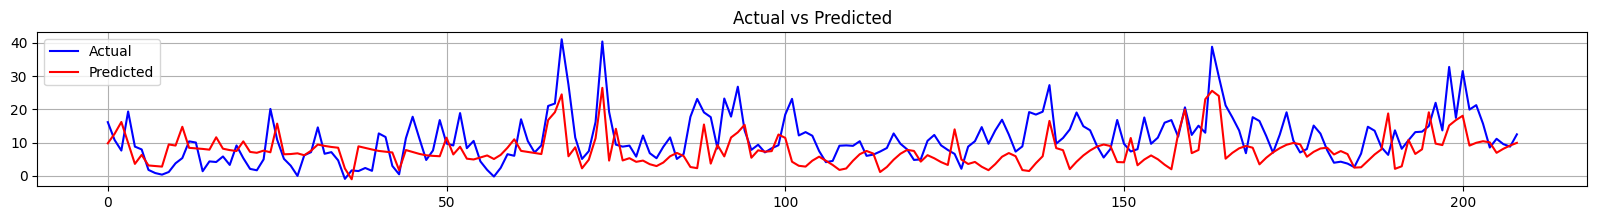

In [ ]:
plt.figure(figsize=(20, 2))
plt.plot(range(len(y)), y, color='blue', label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()